# Opertura d'una nova oficina i predicció de potencials localitzacions futures
 

|   INTEGRANTS                    | Arnau Muñoz Barrera     | Míriam López Sánchez       | Luis Martínez Zamora       | Marc Rodríguez Vitolo
| -------------------------- | ----------------------- | -------------------------- | -------------------------- | --------------------------

### 1. Objectius

L'objectiu d'aquest projecte es centra en buscar ubicacions idònies per obrir noves oficines de la Caixa d'Enginyers, valorant tant la possiblitat d'oficines fixes com oficinse mòbils que arriben a una determinada zona. A més, es desenvoluparà també un model predictiu amb l'ajuda d'IA que permeti identificar potencials localitzacions futures.

### 2. Font de les dades

Com a dades per analitzar en aquest projecte s'han agafat conjunts de dades extrets de fonts oficials: INE, BdE i propis de Caixa d'Enginyers.

### 3. Metodologia seguida

- Recerca de dades
- Anàlisi de dades amb python (realització de gràfiques i extracció d'estadístiques)
- Interpretació de resultats
- Elecció de les millors ubicacions posibles
- Entrenament del model predictiu
- Test del model predictiu
- Extracció de conclusions


### 4. Anàlisi de les dades
##### 1. EDA (exploratory data analysis)
Com a primer pas, caldrà importar totes les llibreries i utilitats que es faran servir en el desenvolupament del projecte:


In [1]:
# Import libraries 

%pip install pandas seaborn scikit-learn category_encoders scikit-optimize scipy openpyxl

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import gist_heat_r
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib.cm as cm

import warnings
warnings.simplefilter(action='ignore')

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\miria\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


A continuació, es farà la importació dels datasets (arxius d'extensió **.xlsx**) a analitzar i s'analitzaran breument:

In [2]:
dataframe_bancs_per_provincia = pd.read_excel('data/Bancs per provincia.xlsx', sheet_name=0, header=0, engine='openpyxl')
print("Estructura Interna de dataframe_bancs_per_provincia: ", dataframe_bancs_per_provincia.shape)

# View complete dataframe with print(dataframe_bancs_per_provincia)
print(dataframe_bancs_per_provincia.head(5))

Estructura Interna de dataframe_bancs_per_provincia:  (53, 5)
     Columna1          Columna2            Columna3                Columna4  \
0  Provincia   Banco de España   Oficinas en España  Entidades de depósito    
1       Álava               NaN                 147                     147   
2    Albacete               NaN                 211                     211   
3     Alacant                 1                 603                     601   
4     Almería               NaN                 286                     285   

                            Columna5  
0  Otras entidades de crédito y EFC   
1                                NaN  
2                                NaN  
3                                  2  
4                                  1  


In [3]:
dataframe_empresa_per_mida_and_provincia = pd.read_excel('data/Empresa per mida y provincia 2008-2022.xlsx', sheet_name=0, header=0, engine='openpyxl')
print("Estructura Interna de dataframe_empresa_per_mida_and_provincia: ", dataframe_empresa_per_mida_and_provincia.shape)

print(dataframe_empresa_per_mida_and_provincia.head(5))

Estructura Interna de dataframe_empresa_per_mida_and_provincia:  (72, 31)
   Unnamed: 0       CCAA Provincias  2009 Total      2009  2010 Total  \
0         NaN  Andalucía    Almería       42535  0.085366       41548   
1         NaN  Andalucía      Cádiz       61021  0.122467       60125   
2         NaN  Andalucía    Córdoba       48222  0.096780       47422   
3         NaN  Andalucía    Granada       58317  0.117040       57618   
4         NaN  Andalucía     Huelva       26263  0.052709       25795   

       2010  2011 Total      2011  2012 Total  ...  2018 Total      2018  \
0  0.084446       40995  0.085065       40516  ...       43406  0.083709   
1  0.122204       58960  0.122342       57288  ...       61786  0.119156   
2  0.096385       46553  0.096598       45278  ...       47874  0.092326   
3  0.117109       56209  0.116634       55183  ...       60020  0.115750   
4  0.052428       24981  0.051836       24168  ...       25236  0.048668   

   2019 Total      2019  2020 

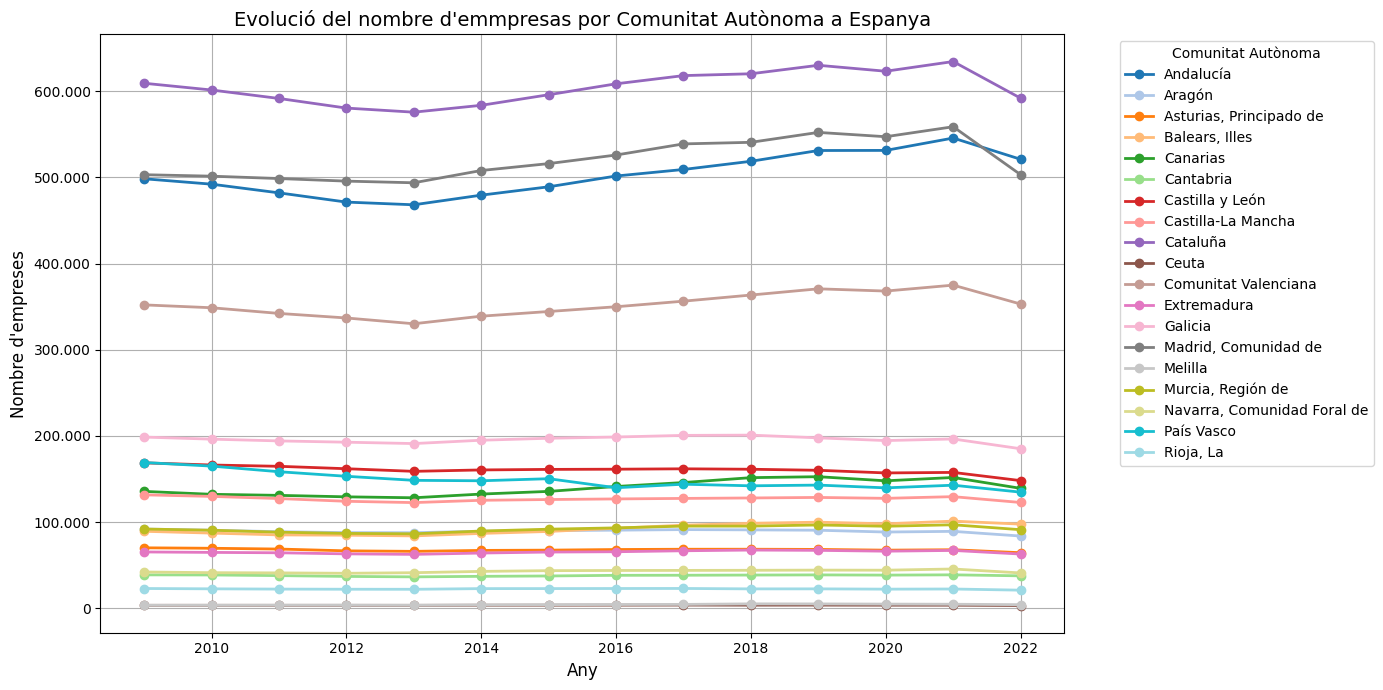

In [4]:
df = dataframe_empresa_per_mida_and_provincia.copy()

prov_col = 'Provincias' if 'Provincias' in df.columns else 'Provincia'

df = df[
    (df['CCAA'].str.strip().str.lower() != 'total') &      
    (df[prov_col].astype(str).str.strip().str.lower() == 'total')
]

columnas_total = [col for col in df.columns if ('Total' in col and col.split()[0].isdigit())]
columnas_total = sorted(columnas_total, key=lambda c: int(c.split()[0]))

df_grouped = df.groupby('CCAA', as_index=False)[columnas_total].sum()

plt.figure(figsize=(14, 7))

comunidades = df_grouped['CCAA'].values
num_comunidades = len(comunidades)
colors = cm.get_cmap('tab20', num_comunidades)

años = [int(col.split()[0]) for col in columnas_total]

for i, row in df_grouped.iterrows():
    comunidad = row['CCAA']
    valores = row[columnas_total].values.astype(float)
    plt.plot(años, valores, marker='o', color=colors(i), label=comunidad, linewidth=2)

plt.xlabel('Any', fontsize=12)
plt.ylabel("Nombre d'empreses", fontsize=12)
plt.title("Evolució del nombre d'emmpresas por Comunitat Autònoma a Espanya", fontsize=14)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', '.')))
plt.legend(title='Comunitat Autònoma', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Punts clau
Es pot observar en el gràfic que la comunitat autònoma amb més empreses és Catalunya, seguida de prop per Andalucía i Madrid. Es pot destacar també la quantitat d'empreses situades a la Comunitat Valenciana.

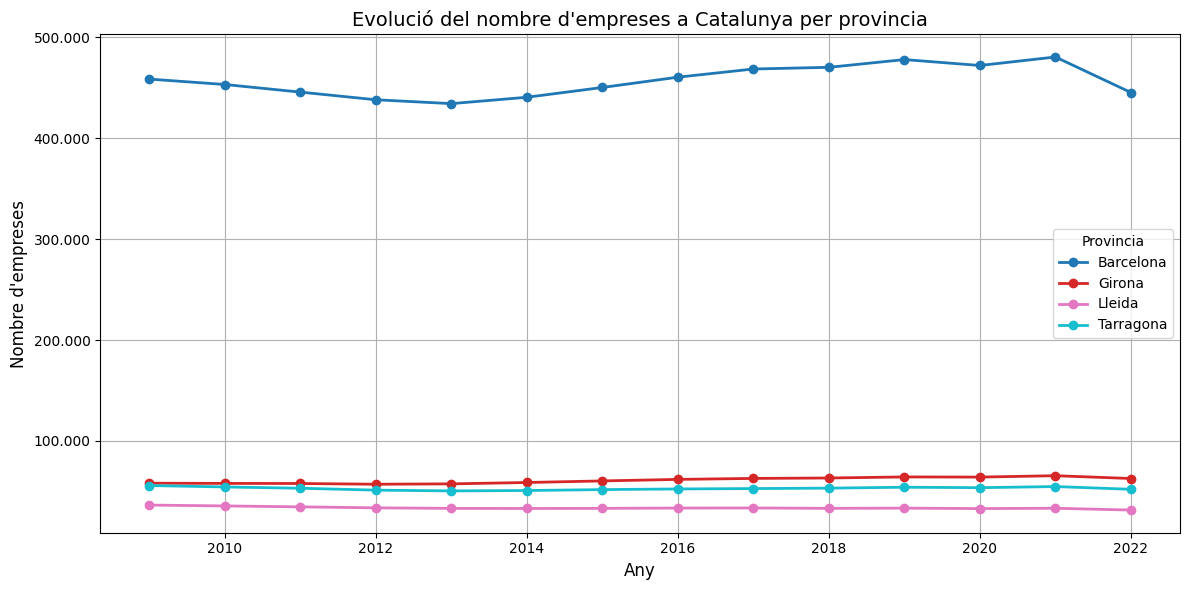

In [5]:
df = dataframe_empresa_per_mida_and_provincia.copy()

prov_col = 'Provincias' if 'Provincias' in df.columns else 'Provincia'

provincias_catalunya = ['Barcelona', 'Girona', 'Lleida', 'Tarragona']
df_cat = df[df[prov_col].isin(provincias_catalunya)]

columnas_total = [col for col in df_cat.columns if ('Total' in col and col.split()[0].isdigit())]
columnas_total = sorted(columnas_total, key=lambda c: int(c.split()[0]))
años = [int(col.split()[0]) for col in columnas_total]

plt.figure(figsize=(12, 6))

colors = cm.get_cmap('tab10', len(provincias_catalunya))

for i, prov in enumerate(provincias_catalunya):
    datos_prov = df_cat[df_cat[prov_col] == prov]
    valores = datos_prov[columnas_total].values.flatten().astype(float)
    plt.plot(años, valores, marker='o', linewidth=2, color=colors(i), label=prov)

plt.xlabel('Any', fontsize=12)
plt.ylabel("Nombre d'empreses", fontsize=12)
plt.title("Evolució del nombre d'empreses a Catalunya per provincia", fontsize=14)

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', '.')))

plt.legend(title='Provincia')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Punts claus
Tal i com es podria suposar, la provincia de Barcelona té la major concentració d'empreses, trobant-se al voltant de 450 000. Les altres tres provincies queden notablement per sota de les 100 000.

In [6]:
dataframe_variacio_PIB_per_capita = pd.read_excel('data/Variació PIB per capita.xlsx', sheet_name=0, header=0, engine='openpyxl')
print("Estructura Interna de dataframe_variacio_PIB_per_capita: ", dataframe_variacio_PIB_per_capita.shape)

print(dataframe_variacio_PIB_per_capita.head(5))


Estructura Interna de dataframe_variacio_PIB_per_capita:  (62, 16)
         AÑO      TIPUS   2009   2010   2011   2012   2013   2014   2015  \
0  ANDALUCÍA       CCAA  17685  17567  17299  16597  16381  16600  17458   
1    Almería  PROVINCIA  19151  18616  17294  17031  16759  17515  18724   
2      Cádiz  PROVINCIA  16899  17054  16881  16196  15843  15703  16255   
3    Córdoba  PROVINCIA  16816  16641  16403  15479  15710  15846  16862   
4    Granada  PROVINCIA  16639  16431  16347  15971  15877  16429  17320   

    2016   2017   2018   2019   2020   2021   2022  
0  17865  18691  19291  19744  17772  19591  21532  
1  20196  21467  21567  22268  20335  20292  22078  
2  16784  17584  18079  18767  16418  18313  20520  
3  17197  17967  18275  18225  16851  18710  20022  
4  17368  17846  18353  19091  17310  18776  20623  


In [7]:
dataframe_variacio_PIB_percentatge = pd.read_excel('data/Variació PIB porcentaje.xlsx', sheet_name=0, header=0, engine='openpyxl')
print("Estructura Interna de dataframe_variacio_PIB_percentatge: ", dataframe_variacio_PIB_percentatge.shape)

print(dataframe_variacio_PIB_percentatge.head(5))

Estructura Interna de dataframe_variacio_PIB_percentatge:  (63, 16)
         AÑO      TIPUS      2009      2010      2011      2012      2013  \
0  ANDALUCÍA       CCAA -0.042334  0.000354 -0.009320 -0.037661 -0.012646   
1    Almería  PROVINCIA -0.073423 -0.017927 -0.066082 -0.011342 -0.014347   
2      Cádiz  PROVINCIA -0.060030  0.016432 -0.003580 -0.038539 -0.021253   
3    Córdoba  PROVINCIA -0.036448 -0.007537 -0.012704 -0.057629  0.011554   
4    Granada  PROVINCIA -0.042923 -0.006667 -0.001451 -0.022298 -0.007408   

       2014      2015      2016      2017      2018      2019      2020  \
0  0.013410  0.052258  0.023877  0.045947  0.032558  0.028317 -0.096263   
1  0.045880  0.076989  0.087118  0.068638  0.008094  0.047211 -0.077435   
2 -0.009186  0.034527  0.032223  0.046976  0.027549  0.039619 -0.123122   
3  0.004983  0.059463  0.015954  0.040222  0.012709 -0.003859 -0.077453   
4  0.032176  0.052094  0.001488  0.026819  0.029684  0.044019 -0.089531   

       2021      2

In [8]:
dataframe_variacio_PIB = pd.read_excel('data/Variació PIB.xlsx', sheet_name=0, header=0, engine='openpyxl')
print("Estructura Interna de dataframe_variacio_PIB_percentatge: ", dataframe_variacio_PIB_percentatge.shape)

print(dataframe_variacio_PIB_percentatge.head(5))

Estructura Interna de dataframe_variacio_PIB_percentatge:  (63, 16)
         AÑO      TIPUS      2009      2010      2011      2012      2013  \
0  ANDALUCÍA       CCAA -0.042334  0.000354 -0.009320 -0.037661 -0.012646   
1    Almería  PROVINCIA -0.073423 -0.017927 -0.066082 -0.011342 -0.014347   
2      Cádiz  PROVINCIA -0.060030  0.016432 -0.003580 -0.038539 -0.021253   
3    Córdoba  PROVINCIA -0.036448 -0.007537 -0.012704 -0.057629  0.011554   
4    Granada  PROVINCIA -0.042923 -0.006667 -0.001451 -0.022298 -0.007408   

       2014      2015      2016      2017      2018      2019      2020  \
0  0.013410  0.052258  0.023877  0.045947  0.032558  0.028317 -0.096263   
1  0.045880  0.076989  0.087118  0.068638  0.008094  0.047211 -0.077435   
2 -0.009186  0.034527  0.032223  0.046976  0.027549  0.039619 -0.123122   
3  0.004983  0.059463  0.015954  0.040222  0.012709 -0.003859 -0.077453   
4  0.032176  0.052094  0.001488  0.026819  0.029684  0.044019 -0.089531   

       2021      2

Donats els gràfics i les sèries disponibles sobre factors clau a Espanya —com ara el PIB i el creixement de la població, que mostren una distribució desigual—, es conclou que el focus d’anàlisi amb més potencial es troba a Catalunya. Es tracta d’una de les zones més poblades, amb dinàmica de creixement i una elevada concentració d’entitats rellevants per al PIB.

A més, es troba que a Catalunya, i segons dades internes de Caixa d’Enginyers, la distribució de socis per regió és la següent:

**⚠️ WARNING:** Distribució ficticia de socis per regions (Temporal)

| Regions              | Socis | % sobre total | Variació interanual | Nota breu                                         |
|---------------------------------|-------:|--------------:|---------------------:|----------------------------------------------------|
| Àrea Metropolitana de Barcelona | 72.000 | 60,0%         | +3,2%                | Alta concentració urbana i hubs tecnològics      |
| Comarques Gironines            | 12.600 | 10,5%         | +4,1%                | Creixement en renovables i turisme de qualitat     |
| Camp de Tarragona              | 10.800 | 9,0%          | +3,7%                | Indústria química i logística portuaria            |
| Penedès                        | 8.400  | 7,0%          | +3,5%                | Agroalimentari i teixit exportador                |
| Comarques Centrals             | 7.200  | 6,0%          | +2,8%                | Pymes industrials diversificades                  |
| Ponent                         | 4.800  | 4,0%          | +2,4%                | Agroindústria i energia                            |
| Terres de l’Ebre               | 2.400  | 2,0%          | +2,0%                | Transició energètica i serveis                  |
| Alt Pirineu i Aran             | 1.800  | 1,5%          | +1,7%                | Turisme sostenible i economia de montanya           |
| **Total**                      | **120.000** | **100%**   | —                    | —                                                  |

